# Echo Meeting 13th of February 2024

In [1]:
import pandas as pd
import pathlib
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
path = pathlib.Path.cwd()

## Overview
This notebook has the following sections: 
1. [Landing on Prompts](#1-landing-on-prompts)
2. [Generating Data](#2-generating-data)
3. [Length Checking](#3-length-checking)
4. [Distance Plots](#4-distance-plots)
5. [Future Work](#5-future-work)

### (1) Landing on Prompts
* "dailymail_cnn_21": "summarize this in a few sentences: "
* "mrpc_21": "paraphrase this: "
* "stories_21": "write a story based on this: "
* "stories_22": "continue the story: "
* "dailydialog_21": "continue the conversation between A and B by writing a single response to the latest speaker. write only a concise response and nothing else: "

As we talked about, these prompts should resemble what a regular user would write (i.e., no "prompt engineering") - maybe with the exception of dailydialog.

### (2) Generating Data
Data has been generated with `vLLM` for all of the above prompts for the temperatures 1, 1.5, 2 for models: 
1. llama-chat 7b (meta-llama/Llama-2-7b-chat-hf)
2. beluga 7b (stabilityai/StableBeluga-7B)
3. mistral 7b (mistralai/Mistral-7B-Instruct-v0.2)
4. llama-chat 13b (meta-llama/Llama-2-13b-chat-hf)

Higher temperatures (already at 2) seem to break generation more easily (more about this later!). We could consider whether we want greedy decoding (temperature = 0) also.

### (3) Length Checking

In [1]:
## insert code here

### (4) Distance Plots

In [47]:
def jitterplot(df:pd.DataFrame, jitter:float=0.3, height_aspect:tuple=(8, 1.5), title:str=None, save_path:pathlib.Path=None):
    # set model as string
    df = df.copy()
    df['model'] = df['model'].astype(str)

    # set order of models
    model_order = ["human", "mistral7b", "beluga7b", "llama2_chat7b", "llama2_chat13b"]

    # create plot
    plot = sns.catplot(
                    data=df, 
                    x="model",
                    y="distance", 
                    hue="dataset", 
                    kind="strip", 
                    dodge=True, 
                    palette="hls", 
                    jitter=jitter, 
                    height=height_aspect[0], 
                    aspect=height_aspect[1], 
                    order=model_order
                    )

    # set labels and title
    plt.subplots_adjust(top=0.9)
    plot.set_axis_labels("Model", "Distance")
    plot.fig.suptitle(title)

    # lims
    plot.set(ylim=(0, 10))

    if save_path: 
        plot.savefig(save_path, dpi=600)

    return plot

In [29]:
# read data 
data_path = path.parents[0] / "results" / "analysis" / "distances_PC_cols.csv"
df = pd.read_csv(data_path)

# get doc length from metrics data
metrics_path = path.parents[0] / "results" / "analysis" / "metrics_data.csv"
metrics_df = pd.read_csv(metrics_path, usecols=["id", "model", "prompt_number", "doc_length"])

# merge dataframes on id and model 
df = df.merge(metrics_df, on=["id", "model", "prompt_number"])

In [49]:
# append "-22" to the string in "dataset" column when prompt number is 22
df["dataset"] = df.apply(lambda x: x["dataset"] + "-22" if x["prompt_number"] == 22 else x["dataset"], axis=1)

#### Temperature 1

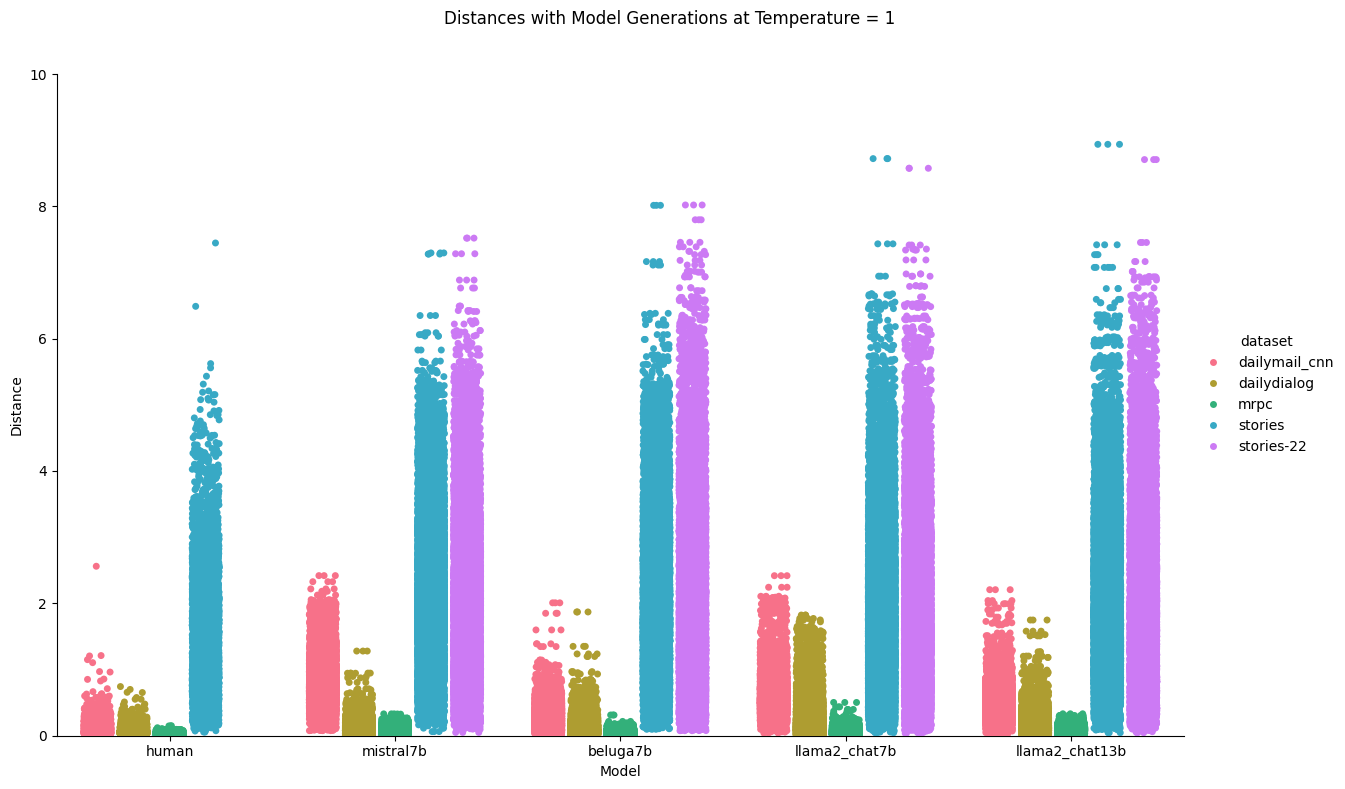

In [50]:
# filter to only include model generations with temp 1 or human
df_temp1 = df_temp1 = df[(df["temperature"] == 1) | (df["model"] == "human")]

# plot 
plot = jitterplot(df_temp1, title="Distances with Model Generations at Temperature = 1")
plot.figure.show()

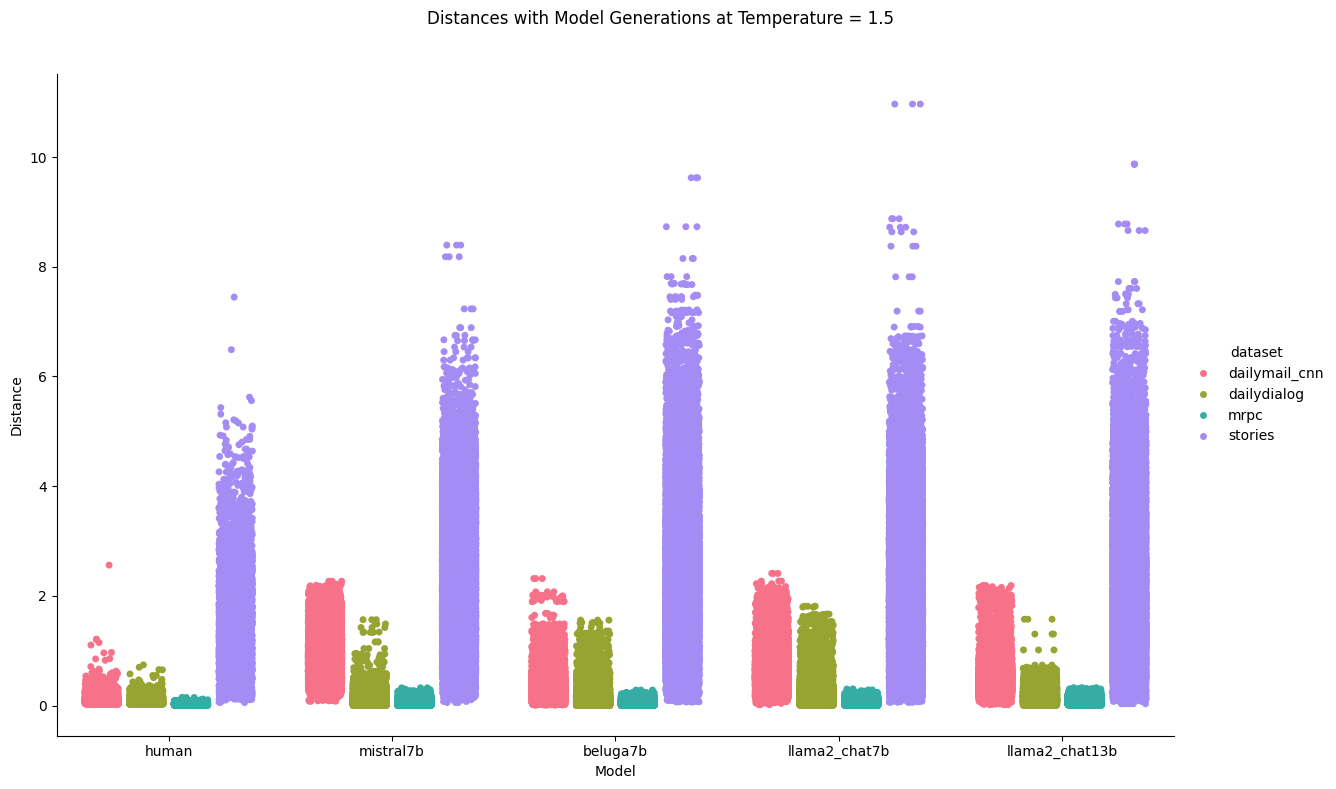

In [46]:
# filter to only include model generations with temp 1 or human
df_temp15 = df[(df["temperature"] == 1.5) | (df["model"] == "human")]

# plot 
plot = jitterplot(df_temp15, title="Distances with Model Generations at Temperature = 1.5")
plot.figure.show()

#### (5) Future Work
* Setting up a classifier pipeline (XGBOOST)? I have been looking at little at Ida's code already :))
* Experimental Design (NB. exam period aka May will be busy!)
* Clean up in repository (not urgent...)